In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split

## Data Wrangling

In [2]:
df = pd.read_csv("dataset/BankChurners.csv")
df.head()

,CustomerId,Geography,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,CreditLevel
0,15762418,Spain,3,121681.82,1,1,0,128643.35,1,8
1,15749905,Spain,6,0.00,1,1,0,50213.81,1,7
2,15600911,France,2,182888.08,1,1,0,3061.00,0,7
3,15572762,Germany,2,102278.79,2,1,0,89822.48,0,2
4,15627848,France,7,109346.13,2,1,0,102665.92,0,7


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerId       9000 non-null   int64  
 1   Geography        9000 non-null   object 
 2   Tenure           9000 non-null   int64  
 3   Balance          9000 non-null   float64
 4   NumOfProducts    9000 non-null   int64  
 5   HasCrCard        9000 non-null   int64  
 6   IsActiveMember   9000 non-null   int64  
 7   EstimatedSalary  9000 non-null   float64
 8   Exited           9000 non-null   int64  
 9   CreditLevel      9000 non-null   int64  
dtypes: float64(2), int64(7), object(1)
memory usage: 703.2+ KB


In [4]:
df.describe()

,CustomerId,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,CreditLevel
count,9.000000e+03,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000
mean,1.569090e+07,5.016111,76168.443138,1.531778,0.706778,0.513556,99868.712786,0.205556,6.374222
std,7.192227e+04,2.900250,62418.871634,0.580732,0.455265,0.499844,57593.168344,0.404129,1.786207
min,1.556570e+07,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000,0.000000,1.000000
25%,1.562853e+07,2.000000,0.000000,1.000000,0.000000,0.000000,50773.897500,0.000000,5.000000
50%,1.569074e+07,5.000000,96889.925000,1.000000,1.000000,1.000000,99691.065000,0.000000,6.000000
75%,1.575316e+07,8.000000,127591.882500,2.000000,1.000000,1.000000,149373.527500,0.000000,8.000000
max,1.581569e+07,10.000000,250898.090000,4.000000,1.000000,1.000000,199970.740000,1.000000,10.000000


In [5]:
df["CreditLevel"].unique()

array([ 8,  7,  2,  6,  5,  4, 10,  3,  9,  1])

In [6]:
for lvl in range(1, 11):
    num_sample = df[df["CreditLevel"]==lvl].shape[0]
    pct = round(100*num_sample/df.shape[0], 6)
    print("CreditLevel {} ({}) accounts for {}%".format(lvl, num_sample, pct))

CreditLevel 1 (12) accounts for 0.133333%
CreditLevel 2 (98) accounts for 1.088889%
CreditLevel 3 (383) accounts for 4.255556%
CreditLevel 4 (895) accounts for 9.944444%
CreditLevel 5 (1425) accounts for 15.833333%
CreditLevel 6 (1883) accounts for 20.922222%
CreditLevel 7 (1899) accounts for 21.1%
CreditLevel 8 (1309) accounts for 14.544444%
CreditLevel 9 (717) accounts for 7.966667%
CreditLevel 10 (379) accounts for 4.211111%


In [7]:
df["Geography"].unique()

array(['Spain', 'France', 'Germany'], dtype=object)

In [8]:
df["Tenure"].unique()

array([ 3,  6,  2,  7,  8,  5,  9, 10,  4,  1,  0])

In [9]:
df["NumOfProducts"].unique()

array([1, 2, 3, 4])

## Data Preprocessing

Targets: 
- Standardization of data in the columns of Tenure, Balance, NumOfProducts, EstimatedSalary
- Convert the "Geography" data to one-hot numeric array
- Update the value of CreditLevel from 1-10 to 0-9
- Remove the CustomerId, as it's not a meaningful feature
- Do resample in the train dataset where the imblanced samples are in credit level 1, 2, 3, 4, 9, 10

In [10]:
df_clean = df.copy()

Data Preprocessing: Standardize the columns: Tenure, NumOfProducts, Balance, EstimatedSalary

In [11]:
from sklearn import preprocessing

std_cols = preprocessing.StandardScaler().fit_transform(df_clean[["Tenure", "Balance", "NumOfProducts", "EstimatedSalary"]])
df_clean[["Tenure", "Balance", "NumOfProducts", "EstimatedSalary"]] = std_cols

In [12]:
std_cols[:5]

array([[-0.69518931,  0.72920103, -0.91575315,  0.49964669],
       [ 0.33926158, -1.22034688, -0.91575315, -0.86221444],
       [-1.04000627,  1.70982851, -0.91575315, -1.68098221],
       [-1.04000627,  0.41833178,  0.80630668, -0.17444414],
       [ 0.68407854,  0.53156248,  0.80630668,  0.04857108]])

In [13]:
df_clean.head()

,CustomerId,Geography,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,CreditLevel
0,15762418,Spain,-0.695189,0.729201,-0.915753,1,0,0.499647,1,8
1,15749905,Spain,0.339262,-1.220347,-0.915753,1,0,-0.862214,1,7
2,15600911,France,-1.040006,1.709829,-0.915753,1,0,-1.680982,0,7
3,15572762,Germany,-1.040006,0.418332,0.806307,1,0,-0.174444,0,2
4,15627848,France,0.684079,0.531562,0.806307,1,0,0.048571,0,7


Data Preprocessing: convert the "Geography" data to one-hot numeric array

In [14]:
df_clean["Geography"].unique()

array(['Spain', 'France', 'Germany'], dtype=object)

Data Preprocessing: update the CreditLevel to 0-9

Data Preprocessing: split train and test dataset. And do resample in the train dataset for levels in [1, 2, 3, 4, 9, 10]

In [222]:
# Data preprocessing
def preprocess(df, geo_one_hot=True):
    df_new = df.copy()
    # reset the label to 0-9
    df_new["CreditLevel"] = df_new["CreditLevel"]-1
    # standardize numerical data columns
    std_cols = preprocessing.StandardScaler().fit_transform(df[["Tenure", "Balance", "NumOfProducts", "EstimatedSalary"]])
    df_new[["Tenure", "Balance", "NumOfProducts", "EstimatedSalary"]] = std_cols
    # set one-hot on geography
    if geo_one_hot:
        geo_onehot = pd.get_dummies(df["Geography"], prefix="Geo")
        df_new = df_new.join(geo_onehot)

    return df_new    

In [223]:
# df_train, df_test = train_test_split(df_clean, test_size=0.1, random_state=42)
# print(df_train.shape, df_test.shape)

In [224]:
# from imblearn.over_sampling import RandomOverSampler
# def get_test_valid_dataset(df, test_size:float, features:list, label:str, is_test_over_sampling:bool=False):
#     df_train, df_test = train_test_split(df, test_size=test_size, random_state=42)
#     oversample = RandomOverSampler(sampling_strategy='minority')
#     X_train_over, y_train_over = oversample.fit_resample(df_train[features], df_train[label])
#     df_train_over = X_train_over[label] = y_train_over
#     return df_train_over, df_test

## Over sampling

In [225]:
# from imblearn.over_sampling import RandomOverSampler

# oversample = RandomOverSampler(sampling_strategy='minority')
# # fit and apply the transform
# df_train_over = oversample.fit_resample(df_train, y)
# # summarize class distribution

## Design Customized Dataset and DataLoader in pytorch
Follow the same procedures in the data preprocessing

In [226]:
# check device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [240]:
# define the customized Dataset
class BankChurnersDataset(torch.utils.data.Dataset):
    def __init__(self, df, feature_cols, label_col):
        """
        params: 
        - df: pandas dataframe
        - feature_cols: input features
        - label_col: label
        return: n/a
        """
        self.feature_cols = feature_cols
        self.label_col = label_col
        self.df = df

    def __getitem__(self, index):
        """
        param: the index of the sample in dataset
        return: input data and the corresponding label
        """
        # return feature, label
        return self.df.iloc[index][self.feature_cols].to_numpy(np.float32), self.df.iloc[index][self.label_col].astype(np.int64)

    def __len__(self):
        return len(self.df)

In [228]:
# preprocess data
df_clean = preprocess(df)
# split df by country
france_df = df_clean[df_clean["Geography"]=="France"]
germany_df = df_clean[df_clean["Geography"]=="Germany"]
spain_df = df_clean[df_clean["Geography"]=="Spain"]

# set the features
numeric_cols = ["Tenure","NumOfProducts","Balance","EstimatedSalary"]
geo_cols = ["Geo_France","Geo_Germany","Geo_Spain"]
feature_cols = ["Balance","EstimatedSalary"] # "Tenure","Balance","NumOfProducts","HasCrCard","IsActiveMember","Exited"
# set the label
label_col = "CreditLevel" 

# define the train and validation dataset
df_train, df_valid = train_test_split(df_clean, test_size=0.1, random_state=42)

train_dataset = BankChurnersDataset(df_train, feature_cols, label_col)
valid_dataset = BankChurnersDataset(df_valid, feature_cols, label_col)

# total_size = len(dataset)
# split_ratio = 0.9
# # split the to train dataset and validation dataset
# train_size = int(total_size*split_ratio)
# train_dataset, valid_dataset = torch.utils.data.random_split(dataset, [train_size, (total_size-train_size)], generator=torch.Generator().manual_seed(42))

print(len(train_dataset))
print(len(valid_dataset))

4059
451


In [245]:
# define the nn model
class BCM(nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.num_features = num_features
        self.fc1 = nn.Linear(num_features, 20)
        self.fc2 = nn.Linear(20, 15)
        self.fc3 = nn.Linear(15, 10)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x    

In [246]:
# set the hyperparameters
learning_rate = 0.01
batch_size = 64
epoch = 100

In [247]:
# Train the network
def train(train_loader, model, criterion, optimizer, epoch):
    losses = {}
    for e in range(epoch):
        running_loss = 0.0
        for i, data in enumerate(train_loader):
            
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            y_pred = model(inputs)
            
            loss = criterion(y_pred, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        losses[e] = running_loss
        print('loss in epoch {}: {}%'.format(e+1, running_loss/len(train_loader.dataset)))
        # running_loss = 0.0
    return losses

In [253]:
model = BCM(len(feature_cols))
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

In [254]:
len(train_dataset)

4059

In [255]:
# define the train data loader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# train
train(train_loader, model, criterion, optimizer, 100)

loss in epoch 1: 0.03534920663779579%
loss in epoch 2: 0.034817631769192045%
loss in epoch 3: 0.03434339512977497%
loss in epoch 4: 0.033911772742298445%
loss in epoch 5: 0.033519484368883704%
loss in epoch 6: 0.03315844853601599%
loss in epoch 7: 0.0328796056139848%
loss in epoch 8: 0.03263239750106747%
loss in epoch 9: 0.03243428614081406%
loss in epoch 10: 0.03226692760539895%
loss in epoch 11: 0.03212931820488117%
loss in epoch 12: 0.03200462141128619%
loss in epoch 13: 0.03193929754004863%
loss in epoch 14: 0.03186076519729528%
loss in epoch 15: 0.031800288318794744%
loss in epoch 16: 0.03174301399683006%
loss in epoch 17: 0.031719474464721%
loss in epoch 18: 0.0317114202457568%
loss in epoch 19: 0.031653605884271%
loss in epoch 20: 0.031612347516851436%
loss in epoch 21: 0.03160745118397978%
loss in epoch 22: 0.031587495419684815%
loss in epoch 23: 0.03156931081937728%
loss in epoch 24: 0.03153896704775032%
loss in epoch 25: 0.03152221792229998%
loss in epoch 26: 0.03150692165823

{0: 143.4824297428131,
 1: 141.3247673511505,
 2: 139.3998408317566,
 3: 137.64788556098938,
 4: 136.05558705329895,
 5: 134.5901426076889,
 6: 133.4583191871643,
 7: 132.45490145683289,
 8: 131.65076744556427,
 9: 130.97145915031433,
 10: 130.41290259361267,
 11: 129.90675830841064,
 12: 129.64160871505737,
 13: 129.32284593582153,
 14: 129.07737028598785,
 15: 128.84489381313324,
 16: 128.74934685230255,
 17: 128.71665477752686,
 18: 128.48198628425598,
 19: 128.31451857089996,
 20: 128.29464435577393,
 21: 128.21364390850067,
 22: 128.13983261585236,
 23: 128.01666724681854,
 24: 127.9486825466156,
 25: 127.88659501075745,
 26: 127.80050730705261,
 27: 127.77835047245026,
 28: 127.71952772140503,
 29: 127.70102608203888,
 30: 127.68870317935944,
 31: 127.49527275562286,
 32: 127.64298474788666,
 33: 127.59291565418243,
 34: 127.51789164543152,
 35: 127.61316871643066,
 36: 127.55345606803894,
 37: 127.42786240577698,
 38: 127.3443615436554,
 39: 127.3812026977539,
 40: 127.406929969

In [256]:
# save state
PATH = './bankchurn_model.pth'
torch.save(model.state_dict(), PATH)

In [257]:
# validation dataset is same with the training dataset to check the accuracy
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)


In [258]:
# check the accuracy of the validation dataset
# load the model
model = BCM(len(feature_cols))
model.load_state_dict(torch.load(PATH))

def valid(model, valid_loader):
    correct  = 0
    total = 0
    label = None
    
    with torch.no_grad():
        for data in valid_loader:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            if (labels.size(0)!=predicted.size(0)):
                print(labels.size(0), predicted.size(0))
                print(labels)
            correct += (predicted == labels).sum().item()
            print(correct, total)
            label = labels[0]

    print('Accuracy of the network on the lable {} is: {}%'.format(label, (100 * correct / total)))



In [259]:
valid(model, valid_loader)    

10 64
33 128
44 192
59 256
69 320
81 384
95 448
95 451
Accuracy of the network on the lable 4 is: 21.06430155210643%


In [260]:
# show the accuracy in each class
correct_pred = {l: 0 for l in range(10)}
total_pred = {l:0 for l in range(10)}

with torch.no_grad():
    for data in valid_loader:
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = model(inputs)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[label.item()] += 1
            total_pred[label.item()] += 1

for l, count in correct_pred.items():
    print("label {} accuracy: {}%".format(l, 100*count/total_pred[l]))

label 0 accuracy: 0.0%
label 1 accuracy: 0.0%
label 2 accuracy: 0.0%
label 3 accuracy: 0.0%
label 4 accuracy: 0.0%
label 5 accuracy: 23.91304347826087%
label 6 accuracy: 76.84210526315789%
label 7 accuracy: 0.0%
label 8 accuracy: 0.0%
label 9 accuracy: 0.0%


In [261]:
# check the count of each class
print(total_pred)
print(correct_pred)

{0: 1, 1: 5, 2: 24, 3: 41, 4: 67, 5: 92, 6: 95, 7: 70, 8: 41, 9: 15}
{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 22, 6: 73, 7: 0, 8: 0, 9: 0}


## Intuition and improvement
From above results, we can find that only class 6 is correctly predicted and other classes are miss predicted. So the proposed solutions to improve the results are:
1. Create multiple models
    - Create logistic regression model for each class (total 10) to get the probability of the class
    - Run test data on 10 models and set the label to the class whose model returns the largest probability

    
2. Feature reduction  

## Create multiple logistic regression models

In [159]:
# define the logistic model
class SingleBCM(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(10, 20)
        self.fc2 = nn.Linear(20, 15)
        self.fc3 = nn.Linear(15, 10)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x    

In [153]:
# Train the network
def train_single_label(train_loader, model, criterion, optimizer, epoch):
    for e in range(epoch):
        running_loss = 0.0
        for i, data in enumerate(train_loader):
            
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            y_pred = model(inputs)
            loss = criterion(y_pred, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # print('loss in epoch {}: {}%'.format(e+1, running_loss/len(train_loader.dataset)))
        # running_loss = 0.0
    print('Finished Training')

In [151]:
def valid_single_label(model, valid_loader, label):
    correct  = 0
    total = 0
    total_prob = 0.0
    
    with torch.no_grad():
        for data in valid_loader:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)

            total_prob += torch.sum(outputs).item()

    print('Average probability on the lable {} is: {}'.format(label, total_prob/total))

Length of train dataset for label 2: 344
Length of validation dataset for label 2: 39
loss in epoch 1: 8.477158657340116%
loss in epoch 2: 0.0%
loss in epoch 3: 0.0%
loss in epoch 4: 0.0%
loss in epoch 5: 0.0%
loss in epoch 6: 0.0%
loss in epoch 7: 0.0%
loss in epoch 8: 0.0%
loss in epoch 9: 0.0%
loss in epoch 10: 0.0%
loss in epoch 11: 0.0%
loss in epoch 12: 0.0%
loss in epoch 13: 0.0%
loss in epoch 14: 0.0%
loss in epoch 15: 0.0%
loss in epoch 16: 0.0%
loss in epoch 17: 0.0%
loss in epoch 18: 0.0%
loss in epoch 19: 0.0%
loss in epoch 20: 0.0%
loss in epoch 21: 0.0%
loss in epoch 22: 0.0%
loss in epoch 23: 0.0%
loss in epoch 24: 0.0%
loss in epoch 25: 0.0%
loss in epoch 26: 0.0%
loss in epoch 27: 0.0%
loss in epoch 28: 0.0%
loss in epoch 29: 0.0%
loss in epoch 30: 0.0%
loss in epoch 31: 0.0%
loss in epoch 32: 0.0%
loss in epoch 33: 0.0%
loss in epoch 34: 0.0%
loss in epoch 35: 0.0%
loss in epoch 36: 0.0%
loss in epoch 37: 0.0%
loss in epoch 38: 0.0%
loss in epoch 39: 0.0%
loss in epoc

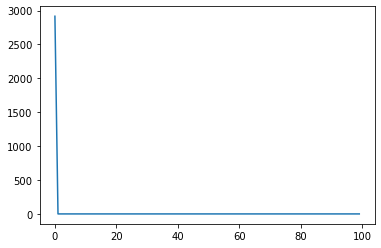

In [178]:
model = SingleBCM()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr =learning_rate)

for label in range(2,3):
    dataset = BankChurnersDataset("dataset/BankChurners.csv", label)
    total_size = len(dataset)
    split_ratio = 0.9
    # split the to train dataset and validation dataset
    train_size = int(total_size*split_ratio)
    train_dataset, valid_dataset = torch.utils.data.random_split(dataset, [train_size, (total_size-train_size)], generator=torch.Generator().manual_seed(42))

    print("Length of train dataset for label {}: {}".format(label, len(train_dataset)))
    print("Length of validation dataset for label {}: {}".format(label, len(valid_dataset)))

    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

    losses = train(train_dataloader, model, criterion, optimizer, 100)

    plt.plot(losses.keys(), losses.values())
    # save results
    PATH = f"./bankchurn_model_{label}.pth"
    torch.save(model.state_dict(), PATH)

    # load the model
    model = SingleBCM()
    model.load_state_dict(torch.load(PATH))
    valid(model, valid_dataloader)
